In [125]:
# conduct PCA on the data
# and visualise

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotnine as pn
import plotnine3d as pn3
from sklearn.cluster import KMeans

import logging
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, Optional

In [126]:
class PCA_Pipeline:
    _DIVERSITY_KEYS = ['div_FUNC_sum',
  'div_LEX_percent',
  'div_VERB_sum',
  'div_FUNC_percent',
  'div_CONT_percent',
  'div_ADV_percent',
  'div_NOUN_percent',
  'div_VERB_percent',
  'div_ADJ_percent']
    _PRONOUN_KEYS = ['pron_FPP_sum', 'pron_FPS_sum']
    _QUANTITY_KEYS = ['quant_PRP$_sum',
  'quant_PUNCT_percent',
  'quant_PUNCT_sum',
  'quant_NEG_sum',
  'quant_UP_sum',
  'quant_UP_percent',
  'quant_VBD_percent',
  'quant_VBD_sum',
  'quant_NUM_sum',
  'quant_WDT_sum',
  'quant_QUOTE_sum',
  'quant_NEG_percent']
    _SENTIMENT_KEYS = ['senti_!_percent', 'senti_CAPS_sum', 'senti_?_sum']
    _AVERAGE_KEYS = ['avg_puncts_per_sent_sum']
    _MEDIAN_SYNTAX_TREE_KEYS = []
    _READABILITY_KEYS = []

    @dataclass
    class NonLatentConfig:
        diversity: bool = True
        pronoun: bool = True
        quantity: bool = True
        sentiment: bool = True
        average: bool = True
        # not include below
        median_syntax_tree: bool = False
        readability: bool = False

        def build_keys(self):
            keys = []
            if self.diversity:
                keys.extend(PCA_Pipeline._DIVERSITY_KEYS)
            if self.pronoun:
                keys.extend(PCA_Pipeline._PRONOUN_KEYS)
            if self.quantity:
                keys.extend(PCA_Pipeline._QUANTITY_KEYS)
            if self.sentiment:
                keys.extend(PCA_Pipeline._SENTIMENT_KEYS)
            if self.average:
                keys.extend(PCA_Pipeline._AVERAGE_KEYS)
            if self.median_syntax_tree:
                keys.extend(PCA_Pipeline._MEDIAN_SYNTAX_TREE_KEYS)
            if self.readability:
                keys.extend(PCA_Pipeline._READABILITY_KEYS)
            return keys

        def build_drop_keys(self):
            keys = []
            if not self.diversity:
                keys.extend(PCA_Pipeline._DIVERSITY_KEYS)
            if not self.pronoun:
                keys.extend(PCA_Pipeline._PRONOUN_KEYS)
            if not self.quantity:
                keys.extend(PCA_Pipeline._QUANTITY_KEYS)
            if not self.sentiment:
                keys.extend(PCA_Pipeline._SENTIMENT_KEYS)
            if not self.average:
                keys.extend(PCA_Pipeline._AVERAGE_KEYS)
            if not self.median_syntax_tree:
                keys.extend(PCA_Pipeline._MEDIAN_SYNTAX_TREE_KEYS)
            if not self.readability:
                keys.extend(PCA_Pipeline._READABILITY_KEYS)
            return keys

    def __init__(self, similarity=True, non_latent: Optional[NonLatentConfig]=NonLatentConfig()):
        self.similarity = similarity
        self.non_latent = non_latent

    def load_dataset_from_file(self):
        sets = {}
        for name in ["train", "valid", "test"]:
            df = pd.read_csv(f"features_{name}.csv")
            y = df["label"].to_numpy()
            labels_to_drop = ["label"]
            if not self.similarity:
                labels_to_drop.append("tf_idf_1_2_harmonic_mean")
            if self.non_latent:
                labels_to_drop.extend(self.non_latent.build_drop_keys())
            else:
                # Delete all keys
                labels_to_drop.extend(PCA_Pipeline.NonLatentConfig().build_keys())
            X = df.drop(labels_to_drop, axis=1).to_numpy()
            sets[name] = (X, y)
        X_train, y_train = sets["train"]
        X_valid, y_valid = sets["valid"]
        X_test, y_test = sets["test"]
        y_train = y_train.astype(int)
        y_valid = y_valid.astype(int)
        y_test = y_test.astype(int)

        X = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_valid), pd.DataFrame(X_test)]).to_numpy()
        y = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_valid), pd.DataFrame(y_test)]).to_numpy()

        return X, y

In [127]:
def plot_PCA(X, y, title="PCA Analysis"):
    dataset = pd.DataFrame(X)
    labels = y

    components = PCA(n_components=2).fit_transform(dataset)
    pca_dataset = pd.DataFrame(components, columns=['pc1', 'pc2'])

    pca_dataset = pd.concat([pca_dataset, pd.DataFrame(labels)], axis=1)
    pca_dataset.rename(columns={0: 'label'}, inplace=True)
    pca_dataset['label'] = pca_dataset['label'].astype('bool')

    pca_plot = (
        pn.ggplot(pca_dataset, pn.aes(
            x='pc1',
            y='pc2',
            color='label')
        )
        + pn.geom_point()

        + pn.ggtitle('PCA of 2 components')

        + pn.theme_538()
        + pn.scale_color_discrete(labels=['fake', 'real'])
        + pn.theme(plot_title=pn.element_text(hjust=0.5))
    )

    # 3D plot of PCA with 3 components
    components = PCA(n_components=3).fit_transform(dataset)
    pca_dataset = pd.DataFrame(components, columns=['pc1', 'pc2', 'pc3'])

    pca_dataset = pd.concat([pca_dataset, pd.DataFrame(labels)], axis=1)
    pca_dataset.rename(columns={0: 'label'}, inplace=True)
    pca_dataset['label'] = pca_dataset['label'].astype('bool')

    pca_plot_3d = (
        pn3.ggplot_3d(pca_dataset, pn.aes(
            x='pc1',
            y='pc2',
            z='pc3',
            color='label')
        )
        + pn3.geom_point_3d()

        + pn.ggtitle('PCA of 3 components')

        + pn.theme_seaborn()
        + pn.scale_color_discrete(labels=['fake', 'real'])
        + pn.theme(plot_title=pn.element_text(hjust=0.5))
    )

    return pca_plot_3d

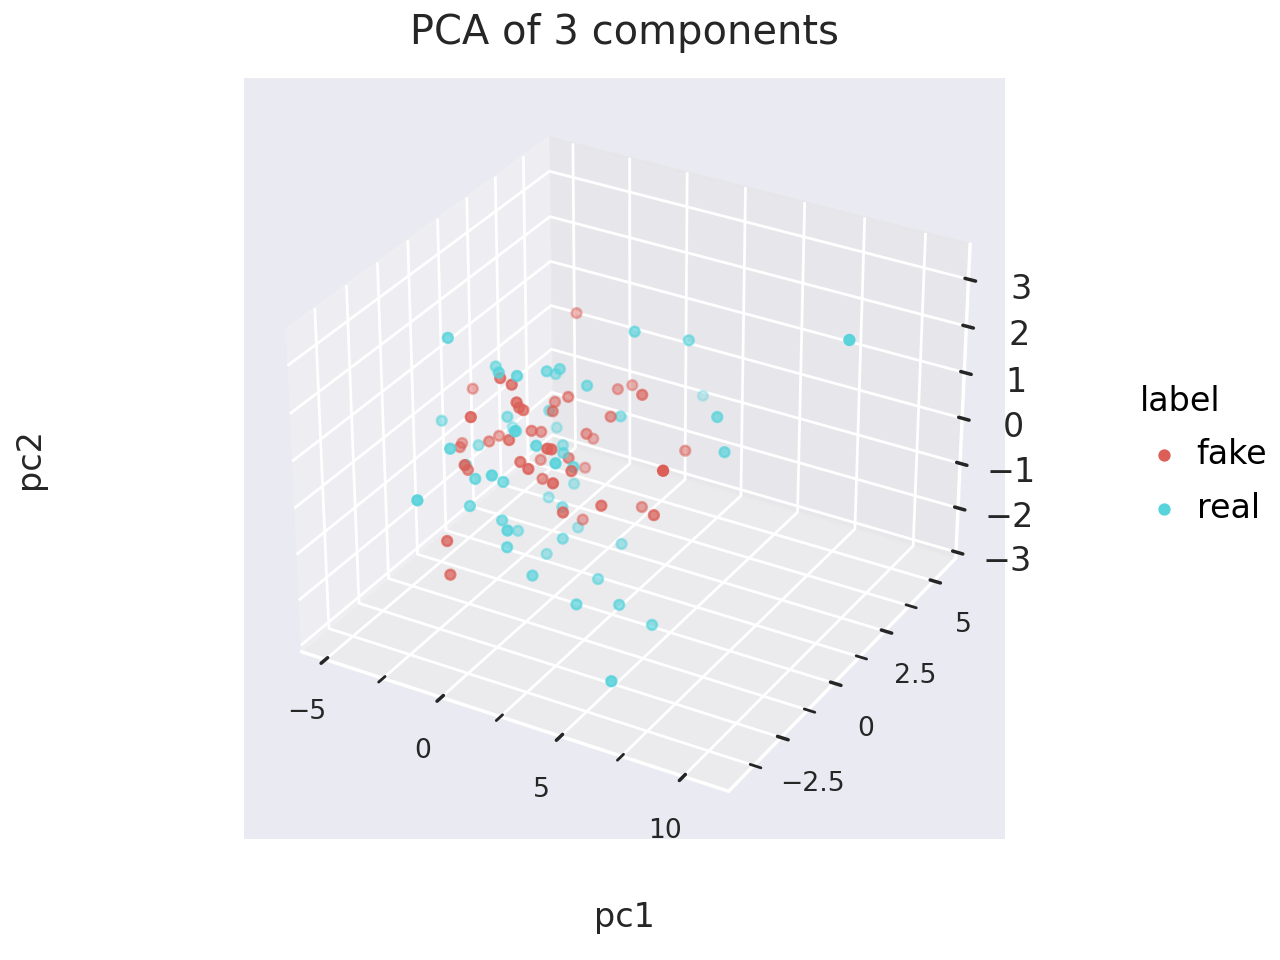

In [128]:
pipeline = PCA_Pipeline(similarity=False, non_latent=None)
X_train, y_train = pipeline.load_dataset_from_file()
plot_PCA(X_train, y_train).draw()

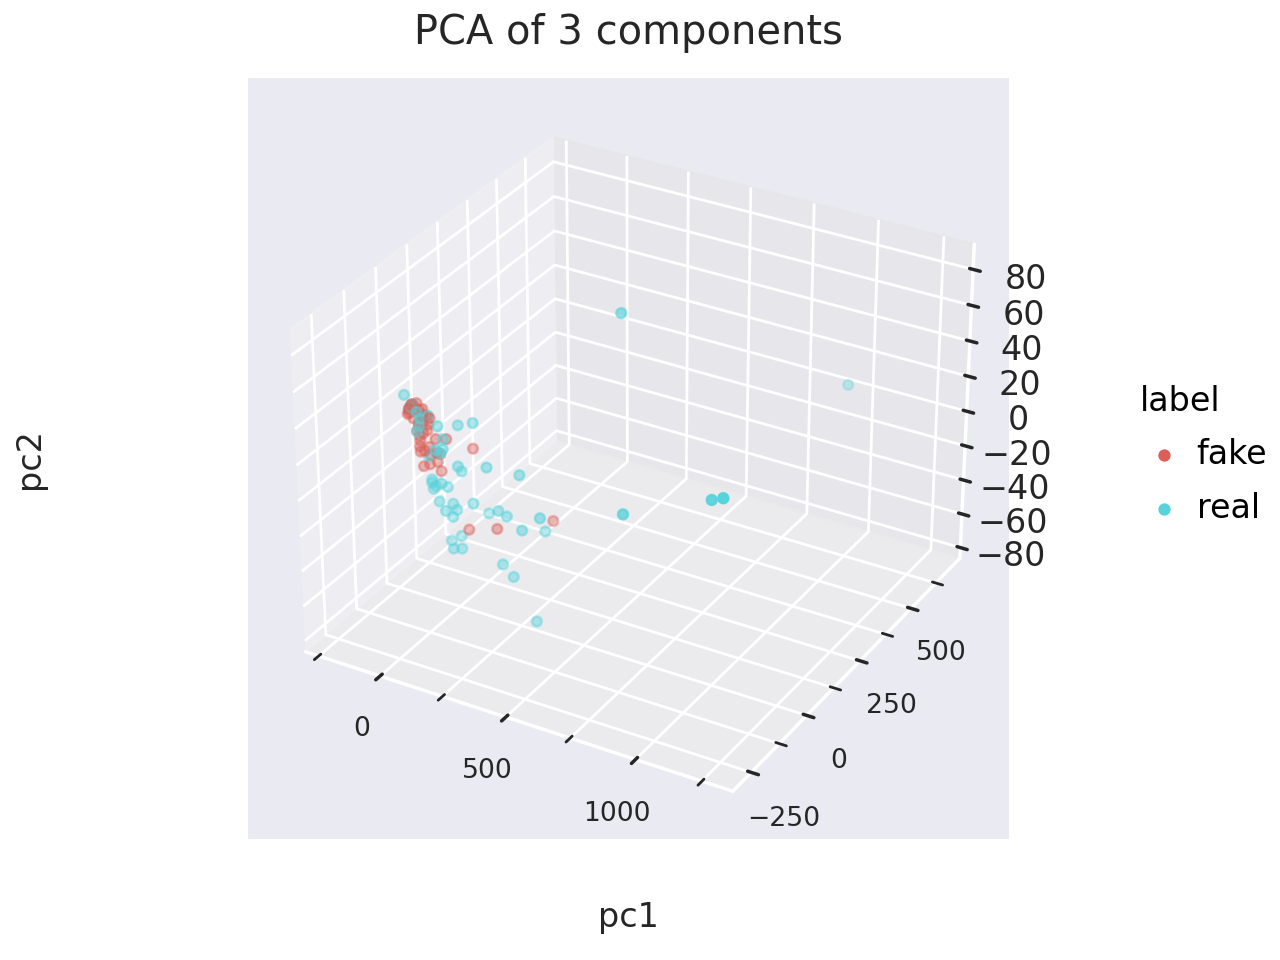

In [129]:
pipeline = PCA_Pipeline(similarity=True)
X_train, y_train = pipeline.load_dataset_from_file()
plot_PCA(X_train, y_train).draw()

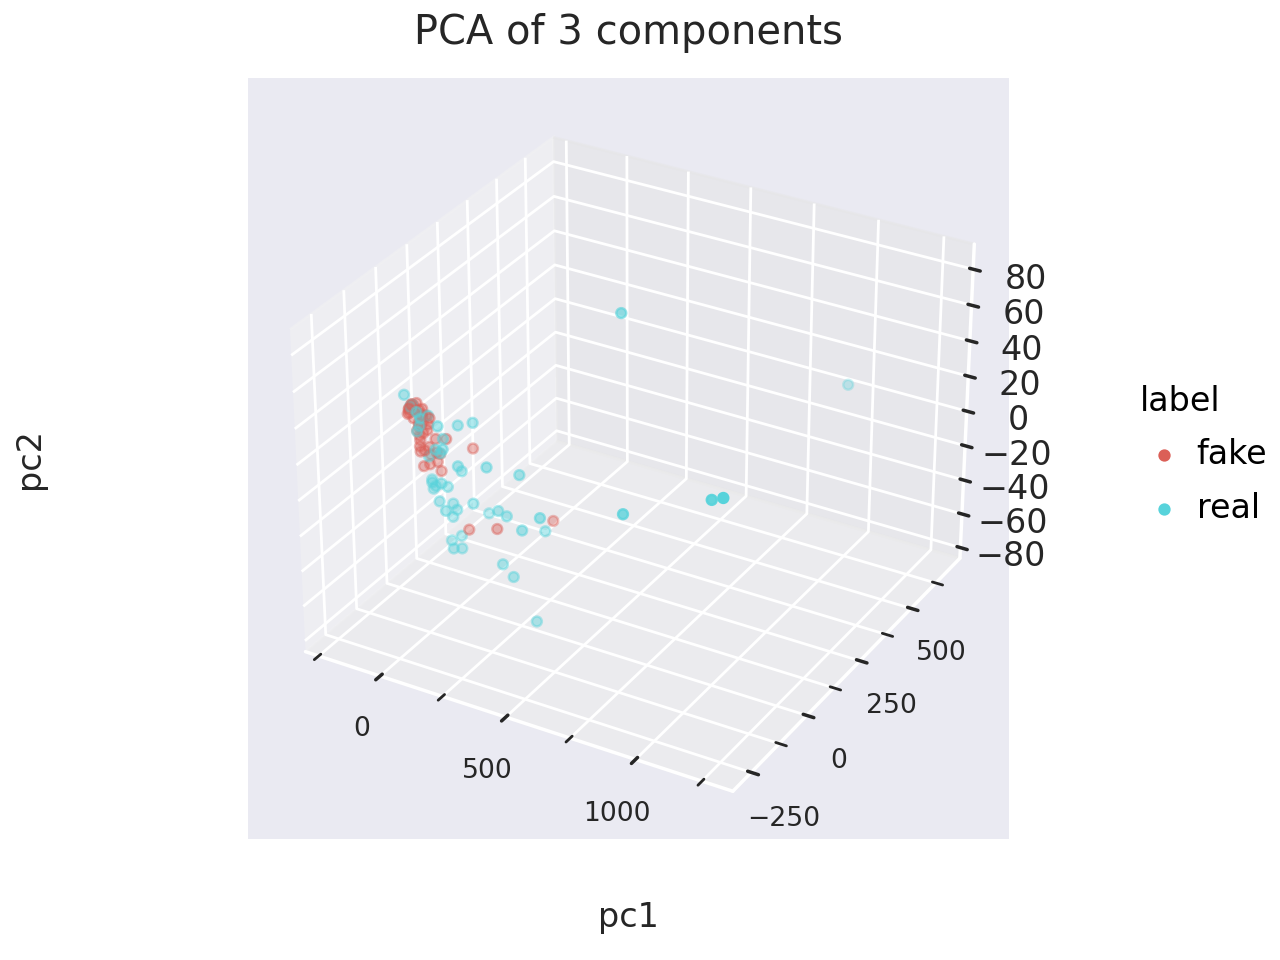

In [130]:
pipeline = PCA_Pipeline(similarity=True)
X_train, y_train = pipeline.load_dataset_from_file()
X_train = X_train[:, 768:]
plot_PCA(X_train, y_train).draw()

In [131]:
def PCA_KMeans(X, y, title="PCA Analysis"):
    dataset = pd.DataFrame(X)
    labels = y

    components = PCA(n_components=2).fit_transform(dataset)
    pca_dataset = pd.DataFrame(components, columns=['pc1', 'pc2'])

    pca_dataset = pd.concat([pca_dataset, pd.DataFrame(labels)], axis=1)
    pca_dataset.rename(columns={0: 'label'}, inplace=True)
    pca_dataset['label'] = pca_dataset['label'].astype('bool')

    pca_plot = (
        pn.ggplot(pca_dataset, pn.aes(
            x='pc1',
            y='pc2',
            color='label')
        )
        + pn.geom_point()
        + pn.scale_color_discrete(labels=['fake', 'real'])

        + pn.ggtitle('PCA with ' + title)

        + pn.theme_538()
        + pn.theme(plot_title=pn.element_text(hjust=0.5))
    )

    kmeans = KMeans(n_clusters=5).fit(pca_dataset)
    pca_dataset['cluster'] = kmeans.labels_
    pca_dataset['cluster'] = pca_dataset['cluster'].astype('category')

    cluster_plot = (
        pn.ggplot(pca_dataset, pn.aes(
            x='pc1',
            y='pc2',
            color='cluster')
        )
        + pn.geom_point()

        + pn.ggtitle('KMeans clustering with ' + title)

        + pn.theme_538()
        + pn.theme(plot_title=pn.element_text(hjust=0.5))
        + pn.theme(legend_position='none')
    )

    return pca_plot, cluster_plot

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


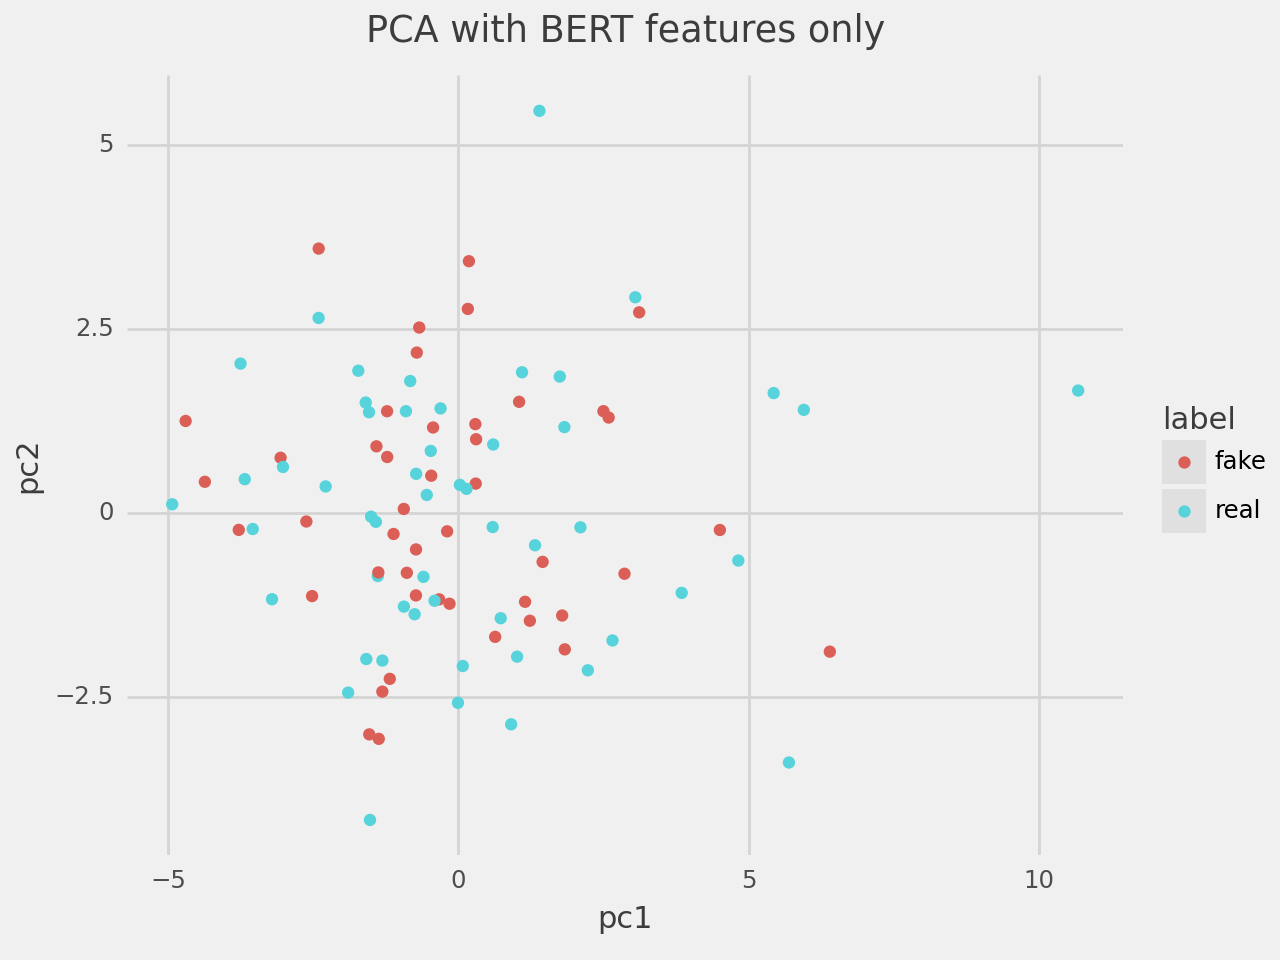

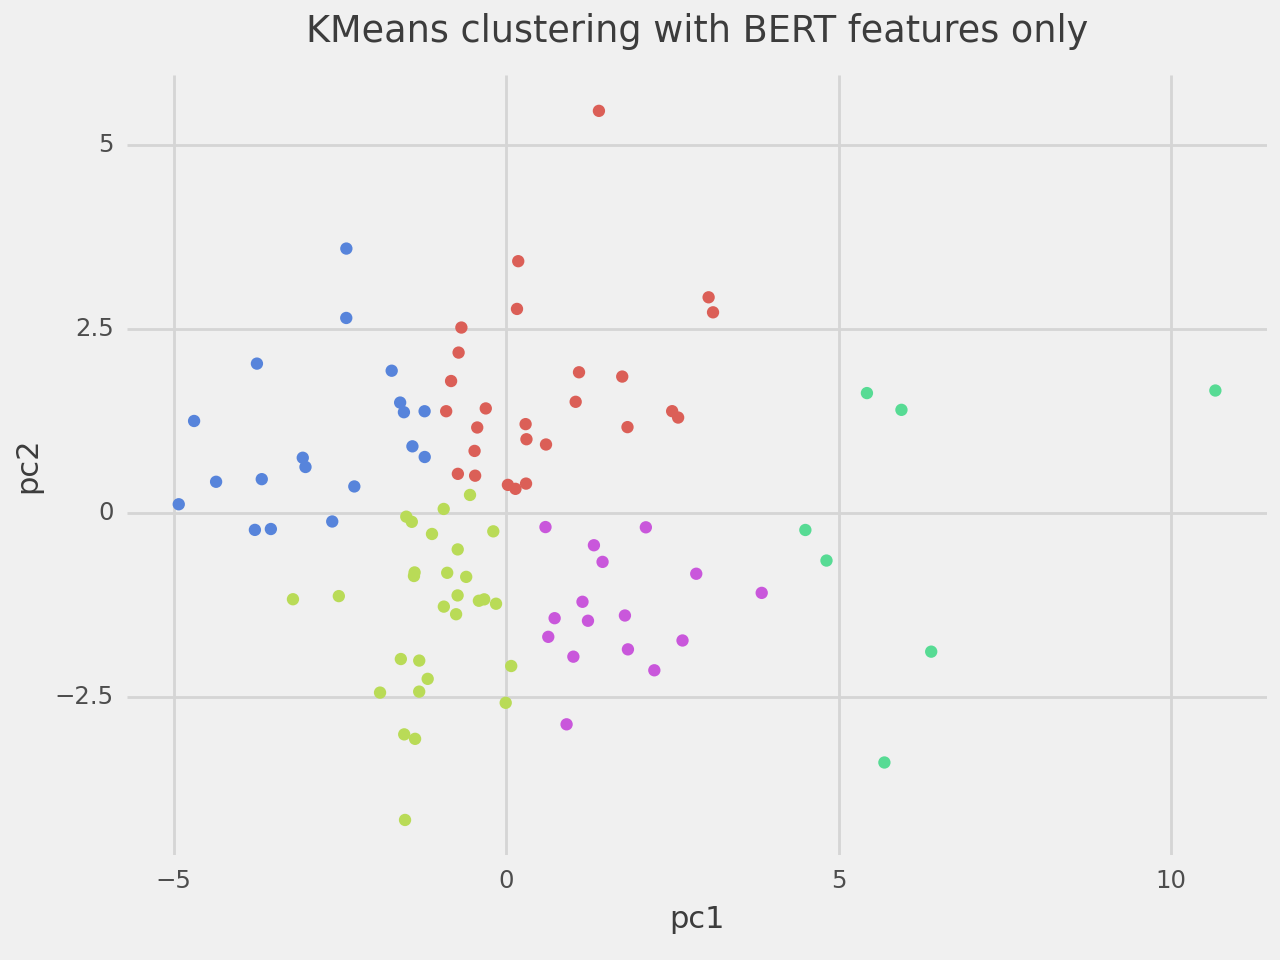

In [132]:
pipeline = PCA_Pipeline(similarity=False, non_latent=None)
X_train, y_train = pipeline.load_dataset_from_file()
a, b = PCA_KMeans(X_train, y_train, title='BERT features only')
print(a, b)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


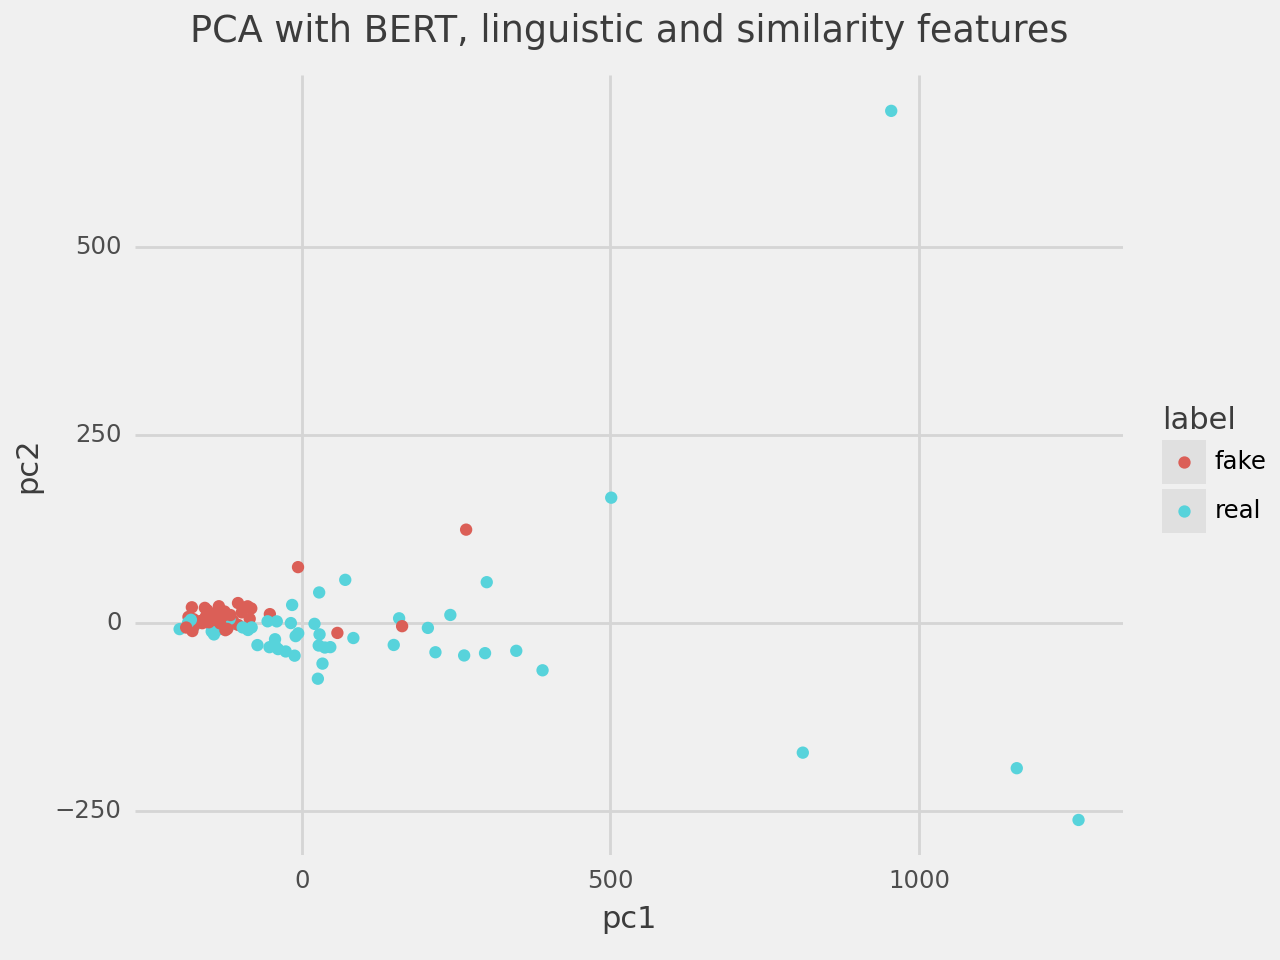

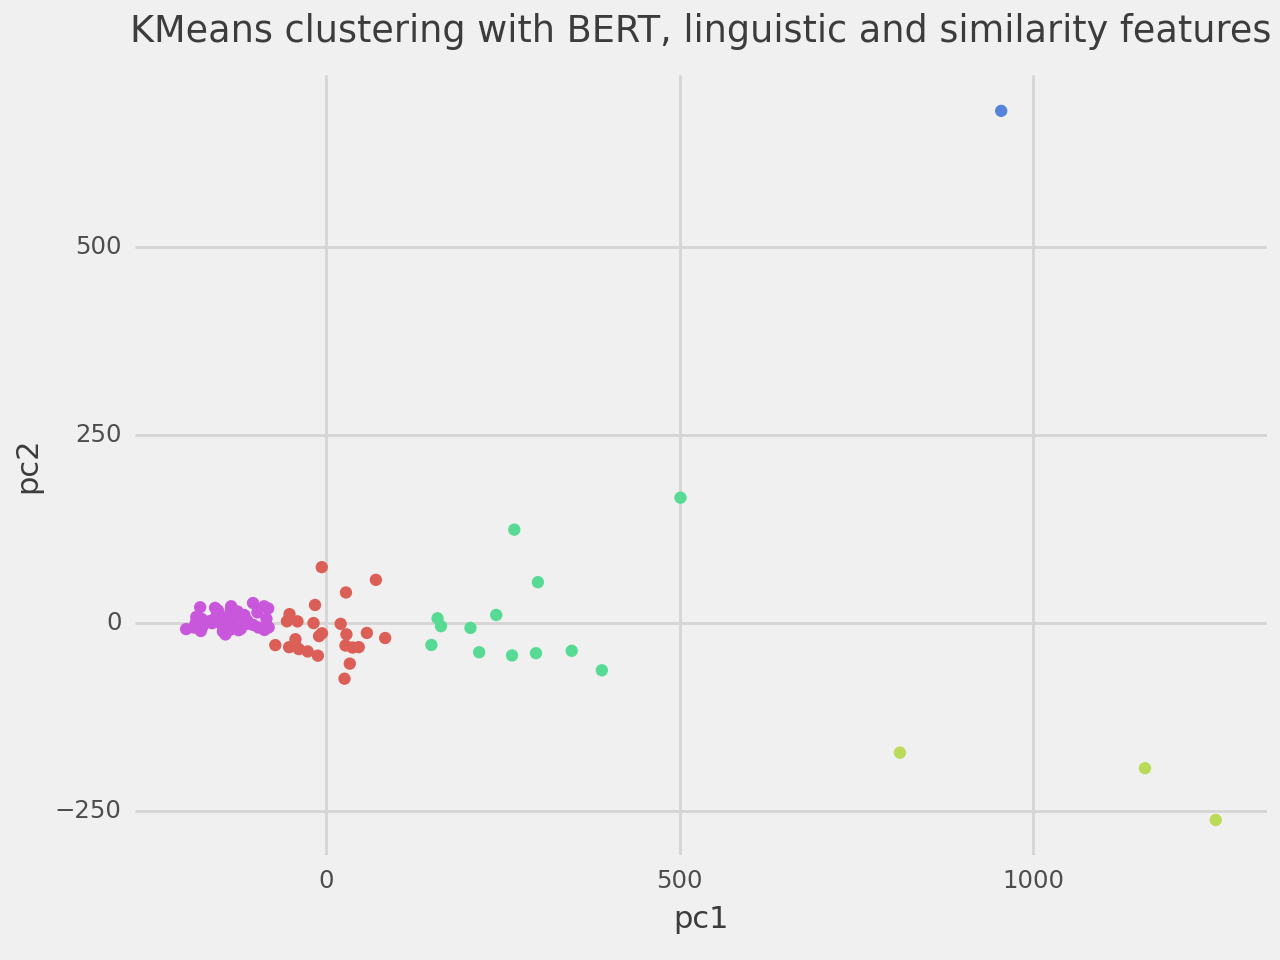

In [133]:
pipeline = PCA_Pipeline(similarity=True)
X_train, y_train = pipeline.load_dataset_from_file()
a, b = PCA_KMeans(X_train, y_train, title='BERT, linguistic and similarity features')
print(a, b)